In [5]:
class MultLayer:
    def _init_(self):
        self.x = None
        self.y = None
    
    def forward(self,x,y):
        self.x = x
        self.y = y
        out = self.x * self.y
        
        return out
    
    def backward(self,dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

class AddLayer:
    def _init_(self):
        pass
    
    def forward(self,x,y):
        return (x+y)
    
    def backward(self,dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy
    
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

#layer
mul_apple_layer = MultLayer()
mul_orange_layer = MultLayer()
add_fruit_layer = AddLayer()
mul_tax_layer = MultLayer()

#forward
apple_price = mul_apple_layer.forward(apple,apple_num)
orange_price = mul_orange_layer.forward(orange,orange_num)
fruit_price = add_fruit_layer.forward(apple_price,orange_price)
price = mul_tax_layer.forward(fruit_price,tax)

print(price)

#backward
dprice = 1
dfruit_price,dtax = mul_tax_layer.backward(dprice)
dorange_price,dapple_price = add_fruit_layer.backward(dfruit_price)
dapple,dapple_num = mul_apple_layer.backward(dapple_price)
dorange,dorgange_num = mul_orange_layer.backward(dorange_price)

print(dfruit_price,dtax)
print(dapple,dapple_num)
print(dorange,dorgange_num)

715.0000000000001
1.1 650
2.2 110.00000000000001
3.3000000000000003 165.0


In [36]:
class MultLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self,x,y):
        self.x = x
        self.y = y
        out = self.x * self.y
        
        return out
    
    def backward(self,dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

class AddLayer:
    def __init__(self):
        pass
    
    def forward(self,x,y):
        return (x+y)
    
    def backward(self,dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self,x):
        #mask记录小于0的索引
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx
class Sigmoid:
    def _init_(self):
        self.out = None
    
    def forward(self,x):
        out = 1/(1+np.exp(-x))
        self.out = out
        
        return out
    
    def backward(sef,dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx
class Affine:
    def __init__(self,w,b):
        self.W = w
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self,x):
        self.x = x
        out = np.dot(x,self.W) + self.b
        
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis = 0)
        
        return dx
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None #softmax的输出
        self.t = None #监督数据
        
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)
        
        return self.loss
    
    def backward(self,dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

In [39]:
class TwoLayerNet:
    
    def __init__(self,input_size,hidden_size,output_size,weight_init_std = 0.01):
        #初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        #生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
        self.lastlayer = SoftmaxWithLoss()
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    #计算损失函数
    #x输入数据，t,监督数据
    def loss(self,x,t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis = 1)
        if t.ndim != 1 :t = np.argmax(t, axis = 1)
        accuracy = np.sum(y==t) / float(x.shape[0])
    
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_W = lambda W:self.loss(x,t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])
        
        return grads
    
    def gradient(self,x,t):
        #forward
        self.loss(x,t)
        
        #backward
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        #设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

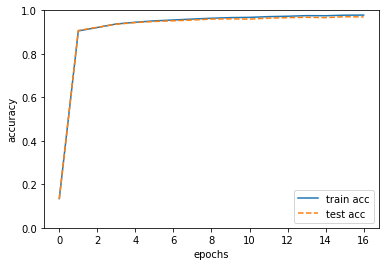

In [42]:
import sys,os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from dataset.mnist import load_mnist
import matplotlib.pylab as plt

#读入数据
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

#超参数
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

#平均每个epoch的重复次数
iter_per_epoch = max(train_size / batch_size,1)

# grad_numerical = network.numerical_gradient(x_batch,t_batch)
# grad_backprop = network.gradient(x_batch, t_batch)

# #求各个权重的绝对误差的平均值
# for key in grad_numerical.keys():
#     diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
#     print(key + ":" + str(diff))

for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch,t_batch)
    
    #更新参数
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
#绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [43]:
print(train_acc_list)

[0.13436666666666666, 0.90535, 0.9212, 0.93745, 0.94535, 0.9517166666666667, 0.9557666666666667, 0.96, 0.9637666666666667, 0.9666166666666667, 0.96775, 0.97115, 0.9729333333333333, 0.9757, 0.9753, 0.9778333333333333, 0.9782833333333333]
